In [1]:
!pip install scikit-learn

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

# 各パス指定

In [3]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'

# 分類数設定

In [4]:
NUM_CLASSES = 5

# 学習データ読み込み

In [5]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [6]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# モデル構築

In [8]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2, )),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(20, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
])

In [9]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dropout (Dropout)                    │ (None, 42)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 20)                  │             860 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 20)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │             210 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 5)                   │              55 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,125 (4.39 KB)

 Trainable params: 1,125 (4.39 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
# モデルチェックポイントのコールバック
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# 早期打ち切り用コールバック
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [11]:
# モデルコンパイル
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# モデル訓練

In [12]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
18/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.2206 - loss: 1.7075
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2787 - loss: 1.6371 - val_accuracy: 0.3551 - val_loss: 1.5422
Epoch 2/1000
19/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3355 - loss: 1.5554 
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3490 - loss: 1.5222 - val_accuracy: 0.4506 - val_loss: 1.4458
Epoch 3/1000
23/30 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.3867 - loss: 1.4398 
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.3880 - loss: 1.4163 - val_accuracy: 0.4554 - val_loss: 1.3200
Epoch 4/1000
20/30 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3805 - loss: 1.3652 
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras

In [13]:
# モデル評価
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9682 - loss: 0.2156 


In [14]:
# 保存したモデルのロード
model = tf.keras.models.load_model(model_save_path)

In [15]:
# 推論テスト
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
[7.4550807e-01 2.5419900e-01 2.8747253e-04 1.2820931e-07 5.3230424e-06]
0


# 混同行列

In [16]:
!pip install pandas seaborn matplotlib

Defaulting to user installation because normal site-packages is not writeable


40/40 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


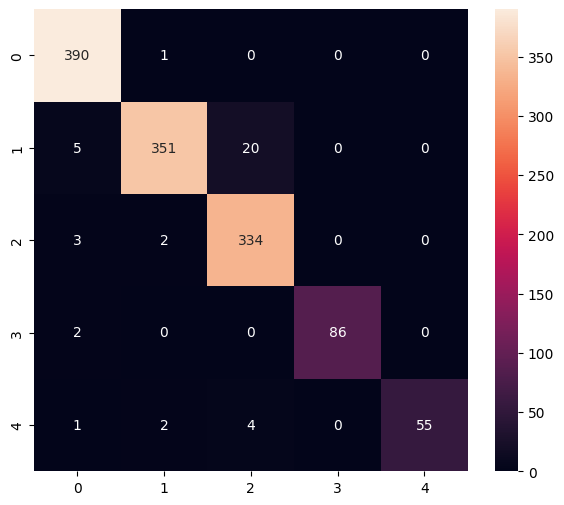

Classification Report
              precision    recall  f1-score   support

           0       0.97      1.00      0.98       391
           1       0.99      0.93      0.96       376
           2       0.93      0.99      0.96       339
           3       1.00      0.98      0.99        88
           4       1.00      0.89      0.94        62

    accuracy                           0.97      1256
   macro avg       0.98      0.96      0.97      1256
weighted avg       0.97      0.97      0.97      1256



In [17]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Tensorflow-Lite用のモデルへ変換

In [18]:
# 推論専用のモデルとして保存
model.save(model_save_path, include_optimizer=False)

In [19]:
# モデルを変換(量子化)
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\toluw\AppData\Local\Temp\tmpssmnsd5e\assets


INFO:tensorflow:Assets written to: C:\Users\toluw\AppData\Local\Temp\tmpssmnsd5e\assets


Saved artifact at 'C:\Users\toluw\AppData\Local\Temp\tmpssmnsd5e'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  2583576692880: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2583576690960: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2583576691920: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2583576693840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2583576693072: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2583576693648: TensorSpec(shape=(), dtype=tf.resource, name=None)


6600

# 推論テスト

In [20]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

C:\Users\toluw\AppData\Roaming\Python\Python312\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


In [21]:
# 入出力テンソルを取得
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [22]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [23]:
%%time
# 推論実施
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 504 μs


In [24]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[7.4550813e-01 2.5419888e-01 2.8747282e-04 1.2820956e-07 5.3230478e-06]
0
